# ボケ判定AIを作ろう！-チュートリアル1
このnotebookは、Nishikaコンペティション [ボケ判定AIを作ろう！](https://www.nishika.com/competitions/) のチュートリアルです。

「ボケて」データを用いて、画像データと文章からそのボケてが面白いか面白くないかを予測することをテーマとしています。

このNotebookでは、画像とテキストそれぞれの特徴量生成を以下のような方法で行っていきます。

- CNNモデルを用いた画像データの特徴量化
- BERTモデルを用いたテキストデータの特徴量化

特徴量の作成では、テキストと画像それぞれ別々で作成していますので、画像データとテキストデータを組み合わせた特徴量を入れることで精度向上が見込めるかも知れませんので、いろいろと試していただければと思います。

| 要素 | 説明 |
| ---- | ---- |
|id | ID|
|odai_photo_file_name | ボケてのお題画像|
|text | ボケての文章|
|is_laugh | 面白さ（面白い：１、面白くない：０）|


ディレクトリ構成は以下のように設定します

```
├── train.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── test.zip
│ ├── xxx.jpg
│ └── yyy.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
└── submission.csv(今回のbaselineで生成されるsubmissionファイル)


```

### setting
ページ上部の「ランタイム」>「ランタイムのタイプを変更」から「GPU」「ハイメモリ」を選択

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

Fri Sep 16 09:21:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Library

In [ ]:
!pip install --quiet transformers==4.18.0
!pip install --quiet tokenizers==0.12.1
!pip install --quiet sentencepiece
!pip install --quiet japanize-matplotlib
!pip install transformers fugashi ipadic >> /dev/null

     |████████████████████████████████| 4.0 MB 10.1 MB/s 
     |████████████████████████████████| 6.6 MB 67.9 MB/s 
     |████████████████████████████████| 120 kB 71.9 MB/s 
     |████████████████████████████████| 880 kB 75.8 MB/s 
     |████████████████████████████████| 1.3 MB 9.6 MB/s 
     |████████████████████████████████| 4.1 MB 7.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import japanize_matplotlib

import torch
import transformers
from transformers import BertTokenizer, BertJapaneseTokenizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import sys
import os
import re
import random

from time import time
from tqdm import tqdm

from contextlib import contextmanager
import lightgbm as lgb

import re
import requests
import unicodedata
import nltk
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
nltk.download(['wordnet', 'stopwords', 'punkt'])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Setting

In [ ]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(42)

In [ ]:
#画像データのzipを解凍します
!unzip /content/drive/MyDrive/Nishika/bokete/train.zip -d /content/train
!unzip /content/drive/MyDrive/Nishika/bokete/test.zip -d /content/test

unzip:  cannot find or open /content/drive/MyDrive/Nishika/bokete/train.zip, /content/drive/MyDrive/Nishika/bokete/train.zip.zip or /content/drive/MyDrive/Nishika/bokete/train.zip.ZIP.
unzip:  cannot find or open /content/drive/MyDrive/Nishika/bokete/test.zip, /content/drive/MyDrive/Nishika/bokete/test.zip.zip or /content/drive/MyDrive/Nishika/bokete/test.zip.ZIP.


In [ ]:
INPUT = "/content/drive/MyDrive/nishika" # 所望のディレクトリに変更してください。
train_image_path = "/content/drive/MyDrive/nishika/train/"
test_image_path = "/content/drive/MyDrive/nishika/test/"

# Read Data
学習データと推論データについて、目的変数の分布などを確認していきます。

In [ ]:
train_df = pd.read_csv(os.path.join(INPUT, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT, "test.csv"))
submission_df = pd.read_csv(os.path.join(INPUT, "sample_submission.csv"))

In [ ]:
print(f"train_data: {train_df.shape}")
display(train_df.head())

print(f"test_data: {test_df.shape}")
display(test_df.head())

train_data: (24962, 4)


,id,odai_photo_file_name,text,is_laugh
0,ge5kssftl,9fkys1gb2r.jpg,君しょっちゅうソレ自慢するけど、ツムジ２個ってそんなに嬉しいのかい？,0
1,r7sm6tvkj,c6ag0m1lak.jpg,これでバレない？授業中寝てもバレない？,0
2,yp5aze0bh,whtn6gb9ww.jpg,「あなたも感じる？」\n『ああ…、感じてる…』\n「後ろに幽霊いるよね…」\n『女のな…』,0
3,ujaixzo56,6yk5cwmrsy.jpg,大塚愛聞いてたらお腹減った…さく、らんぼと牛タン食べたい…,0
4,7vkeveptl,0i9gsa2jsm.jpg,熊だと思ったら嫁だった,0


test_data: (6000, 3)


,id,odai_photo_file_name,text
0,rfdjcfsqq,nc1kez326b.jpg,僕のママ、キャラ弁のゆでたまごに８時間かかったんだ
1,tsgqmfpef,49xt2fmjw0.jpg,かわいいが作れた！
2,owjcthkz2,9dtscjmyfh.jpg,来世の志茂田景樹
3,rvgaocjyy,osa3n56tiv.jpg,ちょ、あの、オカン、これ水風呂やねんけど、なんの冗談??
4,uxtwu5i69,yb1yqs4pvb.jpg,「今日は皆さんにザリガニと消防車の違いを知ってもらいたいと思います」『どっちも同じだろ。両方...


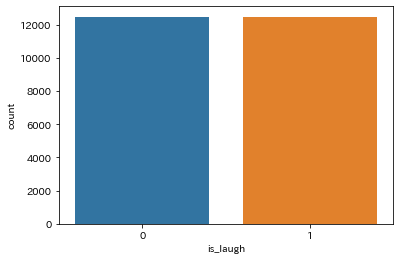

In [ ]:
# 目的変数の分布を確認する
sns.countplot(x="is_laugh", data=train_df)

In [ ]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

In [ ]:
# 画像の重複があるか確認する
print(train_df["odai_photo_file_name"].duplicated().sum())
print(test_df["odai_photo_file_name"].duplicated().sum())

0
0


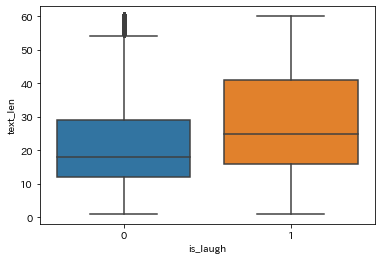

In [ ]:
# 文書の長さとflagの関係を確認する
train_df["text_len"] = train_df["text"].str.len()
test_df["text_len"] = test_df["text"].str.len()

sns.boxplot(x="is_laugh", y="text_len", data=train_df)

目的変数の分布と、文章の長さについて確認しました。続いて、実際に画像と文章を合わせてみてみましょう。

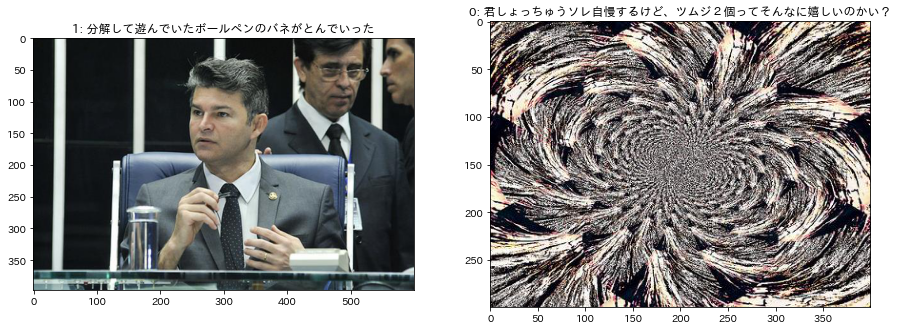

In [ ]:
# データ内にあるボケてを確認してみる

fig = plt.figure(figsize=(15,7))

data1 = train_df[train_df["is_laugh"]==1]
image_path1 = train_image_path + data1.iloc[0]["odai_photo_file_name"]
img1 = img = Image.open(image_path1)

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(img1)
plt.title(str(data1.iloc[0]["is_laugh"])+ ": "+ data1.iloc[0]["text"])

data2 = train_df[train_df["is_laugh"]==0]
image_path2 = train_image_path + data2.iloc[0]["odai_photo_file_name"]
img2 = img = Image.open(image_path2)

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(img2)
plt.title(str(data2.iloc[0]["is_laugh"])+ ": "+ data2.iloc[0]["text"])

plt.show()

個人的な主観も含まれてしまいますが、以下のようなことがわかってきました。  
- ファイル名で確認すると、画像の重複はtrainとtestではない。
- ボケての文章の長さを確認すると、面白いボケての方が文章が長い傾向
- 画像とボケての文章を見てみると、確かに１と０で差がありそう（個人的に０の方はどのようにボケているのかが少しわかりにくい感じがあります）

今回は単純に文章の長さのみを確認しましたが、他にも文章自体について注目していくと、面白さに関する知見というのが見えてくるかも知れません。


# Create Image Features

ボケてというものは、画像と文章の組み合わせで面白さを表現しているので、以下にして画像のデータと文章のデータをモデルに学習させるかがポイントになってくるかと思います。

画像のデータを特徴量として用いるために、今回はDenseNet121の学習済みモデルを用います。

In [ ]:
import cv2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K
from tqdm import tqdm, tqdm_notebook
from keras.applications.densenet import preprocess_input, DenseNet121

In [ ]:
class CFG:
    img_size = 224
    batch_size = 17

In [ ]:
def resize_to_square(im):
    old_size = im.shape[:2] 
    ratio = float(CFG.img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # 画像サイズを224×224に変更します
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = CFG.img_size - new_size[1]
    delta_h = CFG.img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im


def load_image(ids, is_train=True):
  if is_train:
    image = cv2.imread(train_image_path+ids)
  else:
    image = cv2.imread(test_image_path+ids)
  new_image = resize_to_square(image)
  new_image = preprocess_input(new_image)
  return new_image

In [ ]:
image_df_train = train_df[["id", "odai_photo_file_name"]].copy()
image_df_train.head()

,id,odai_photo_file_name
0,ge5kssftl,9fkys1gb2r.jpg
1,r7sm6tvkj,c6ag0m1lak.jpg
2,yp5aze0bh,whtn6gb9ww.jpg
3,ujaixzo56,6yk5cwmrsy.jpg
4,7vkeveptl,0i9gsa2jsm.jpg


In [ ]:
image_ids = image_df_train["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1

In [ ]:
features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id)
        except:
          print("Error")
    batch_preds = m.predict(batch_images)
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

100%|██████████| 1469/1469 [2:34:19<00:00,  6.30s/it]


In [ ]:
image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("DenseNet121_").reset_index()
image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

In [ ]:
# trainのデータに結合します。
train_df = pd.merge(train_df, image_feature, on="odai_photo_file_name", how="left")

In [ ]:
train_df.shape

(24962, 261)

In [ ]:
# testデータでも同様なことを行って行きます
image_df_test = test_df[["id", "odai_photo_file_name"]].copy()

image_ids = image_df_test["odai_photo_file_name"].values
n_batches = len(image_ids) // CFG.batch_size + 1


features = {}
for b in tqdm(range(n_batches)):
    start = b*CFG.batch_size
    end = (b+1)*CFG.batch_size
    batch_ids = image_ids[start:end]
    batch_images = np.zeros((len(batch_ids),CFG.img_size,CFG.img_size,3))
    for i,image_id in enumerate(batch_ids):
        try:
            batch_images[i] = load_image(image_id, is_train=False)
        except:
          print("Error")
    batch_preds = m.predict(batch_images)
    for i,image_id in enumerate(batch_ids):
        features[image_id] = batch_preds[i]

image_feature = pd.DataFrame.from_dict(features, orient='index').add_prefix("DenseNet121_").reset_index()
image_feature.rename(columns={"index":"odai_photo_file_name"}, inplace=True)

test_df = pd.merge(test_df, image_feature, on="odai_photo_file_name", how="left")

100%|██████████| 353/353 [37:18<00:00,  6.34s/it]


In [ ]:
test_df.shape

(6000, 260)

# Create Text Features

続いてボケての文章について、BERTモデルを用いて特徴量化していきます。
特徴量化については、以下のディスカッションを参考にさせていただきます。  
[japanese-roberta-baseでテキストデータをembeddingする(小説家になろう ブクマ数予測 \~”伸びる”タイトルとは？\~ より)](https://www.nishika.com/competitions/21/topics/163)


In [ ]:
def clean_text(text):
    replaced_text = text.lower()
    replaced_text = re.sub(r'[【】]', ' ', replaced_text)       # 【】の除去
    replaced_text = re.sub(r'[（）()]', ' ', replaced_text)     # （）の除去
    replaced_text = re.sub(r'[［］\[\]]', ' ', replaced_text)   # ［］の除去
    replaced_text = re.sub(r'[『』]', ' ', replaced_text)   # 『』の除去
    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?:\/\/.*?[\r\n ]', '', replaced_text)  # URLの除去
    replaced_text = re.sub(r'　', ' ', replaced_text)  # 全角空白の除去
    replaced_text = re.sub(r' ', '', replaced_text)  # 空白の除去
    return replaced_text


def clean_html_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_html_and_js_tags(html_text):
    soup = BeautifulSoup(html_text, 'html.parser')
    [x.extract() for x in soup.findAll(['script', 'style'])]
    cleaned_text = soup.get_text()
    cleaned_text = ''.join(cleaned_text.splitlines())
    return cleaned_text


def clean_url(html_text):
    cleaned_text = re.sub(r'http\S+', '', html_text)
    return cleaned_text


def normalize(text):
    normalized_text = normalize_unicode(text)
    normalized_text = normalize_number(normalized_text)
    normalized_text = lower_text(normalized_text)
    return normalized_text


def lower_text(text):
    return text.lower()


def normalize_unicode(text, form='NFKC'):
    normalized_text = unicodedata.normalize(form, text)
    return normalized_text


def normalize_number(text):
    replaced_text = re.sub(r'\d+', '0', text)
    return replaced_text


def text_cleaning(text):
    text = clean_text(text)
    text = clean_html_tags(text)
    text = clean_html_and_js_tags(text)
    text = clean_url(text)
    text = normalize(text)
    text = lower_text(text)
    text = normalize_unicode(text)

    return text

In [ ]:
class BertSequenceVectorizer:
    def __init__(self, model_name: str):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model_name = model_name
        self.tokenizer = transformers.T5Tokenizer.from_pretrained(self.model_name)
        self.tokenizer.do_lower_case = True 
        self.bert_model = transformers.RobertaModel.from_pretrained(self.model_name)
        self.bert_model = self.bert_model.to(self.device)
        self.max_len = 256


    def vectorize(self, sentence : str) -> np.array:
        inp = self.tokenizer.encode(sentence)
        len_inp = len(inp)

        if len_inp >= self.max_len:
            inputs = inp[:self.max_len]
            masks = [1] * self.max_len
        else:
            inputs = inp + [0] * (self.max_len - len_inp)
            masks = [1] * len_inp + [0] * (self.max_len - len_inp)

        inputs_tensor = torch.tensor([inputs], dtype=torch.long).to(self.device)
        masks_tensor = torch.tensor([masks], dtype=torch.long).to(self.device)

        bert_out = self.bert_model(inputs_tensor, masks_tensor)
        seq_out, pooled_out = bert_out['last_hidden_state'], bert_out['pooler_output']

        if torch.cuda.is_available():    
            return seq_out[0][0].cpu().detach().numpy()
        else:
            return seq_out[0][0].detach().numpy()

In [ ]:
BSV = BertSequenceVectorizer('rinna/japanese-roberta-base')

## テキストの欠損値を補間します
train_df["text"] = train_df["text"].fillna('NaN')
test_df["text"] = test_df["text"].fillna('NaN')

## BERT特徴量 
features_text_train = np.stack(train_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)
features_text_test = np.stack(test_df["text"].fillna("").map(lambda x: BSV.vectorize(x).reshape(-1)).values)

Downloading:   0%|          | 0.00/787k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/153 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/259 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/663 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at rinna/japanese-roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at rinna/japanese-roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to b

In [ ]:
## テキスト特徴量
features_text_train_df = pd.DataFrame(features_text_train).add_prefix("Roberta-text")
features_text_test_df = pd.DataFrame(features_text_test).add_prefix("Roberta-text")

train_df = pd.concat([train_df, features_text_train_df], axis=1)
test_df = pd.concat([test_df, features_text_test_df], axis=1)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(24962, 772)
(6000, 771)


In [ ]:
train_df.to_csv('/content/drive/MyDrive/nishika/embeded/embedding_train_densenet151_rinna_roberta_base.csv')

In [ ]:
test_df.to_csv('/content/drive/MyDrive/nishika/embeded/embedding_test_densenet151_rinna_roberta_base.csv')

In [ ]:
train_df["is_laugh"].value_counts()

0    12481
1    12481
Name: is_laugh, dtype: int64

# Data Split

In [ ]:
# 学習データと評価データに分割します
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df["is_laugh"])

train_y = train_df["is_laugh"]
train_x = train_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

valid_y = valid_df["is_laugh"]
valid_x = valid_df.drop(["id", "odai_photo_file_name", "text","is_laugh"], axis=1)

test_x = test_df.drop(["id", "odai_photo_file_name", "text"], axis=1)

In [ ]:
print(train_x.shape)
print(valid_x.shape)

(19969, 1025)
(4993, 1025)


# Model

In [ ]:
lgbm_params = {  
    "n_estimators": 20000,
    "objective": 'binary',
    "learning_rate": 0.05,
    "num_leaves": 32,
    "random_state": 71,
    "n_jobs": -1,
    "importance_type": "gain",
    'colsample_bytree': .8,
    "reg_lambda": 5,
    "max_depth":5,
    }

lgtrain = lgb.Dataset(train_x, train_y)
lgvalid = lgb.Dataset(valid_x, valid_y)

lgb_clf = lgb.train(
    lgbm_params,
    lgtrain,
    num_boost_round=10000,
    valid_sets=[lgtrain, lgvalid],
    valid_names=['train','valid'],
    early_stopping_rounds=50,
    verbose_eval=50
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 50 rounds.
[50]	train's binary_logloss: 0.611658	valid's binary_logloss: 0.661414
[100]	train's binary_logloss: 0.571996	valid's binary_logloss: 0.659456
[150]	train's binary_logloss: 0.539215	valid's binary_logloss: 0.659053
[200]	train's binary_logloss: 0.511231	valid's binary_logloss: 0.659535
Early stopping, best iteration is:
[167]	train's binary_logloss: 0.530272	valid's binary_logloss: 0.658661


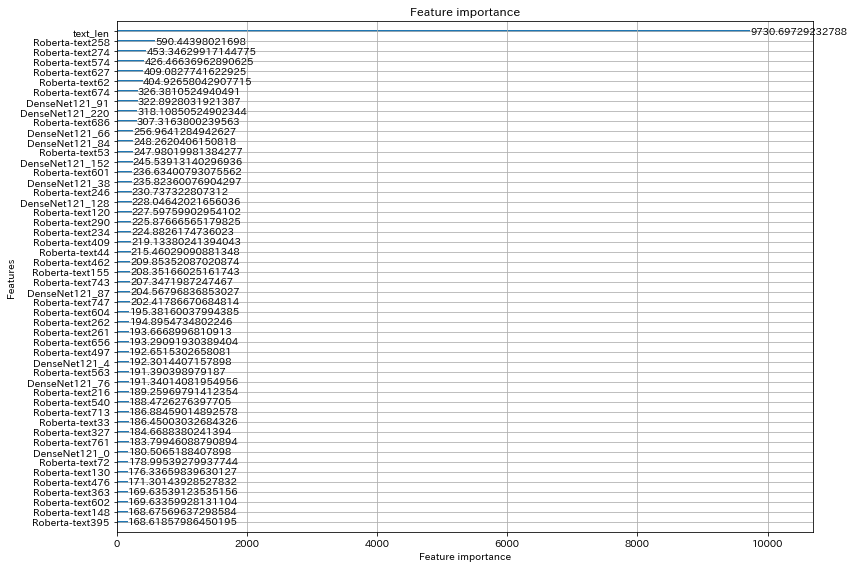

In [ ]:
# 特徴量の重要度を可視化。
lgb.plot_importance(lgb_clf, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()

In [ ]:
# 評価指標はlog lossだが、accuracyも見てみる

val_pred = lgb_clf.predict(valid_x, num_iteration=lgb_clf.best_iteration)
val_pred_max = np.round(lgb_clf.predict(valid_x)).astype(int)  # クラスに分類
accuracy = sum(valid_y == val_pred_max) / len(valid_y)
print(accuracy)

0.6068495894251953


Text(0.5, 52.0, 'Predict')

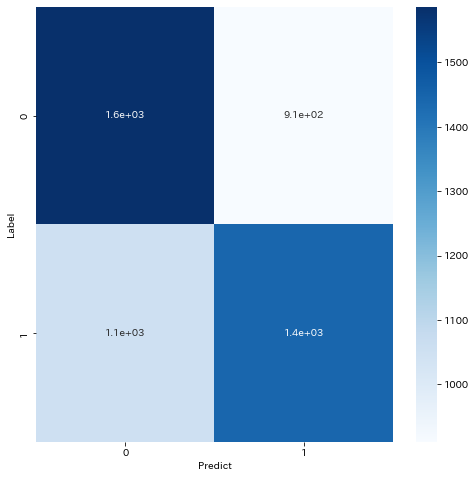

In [ ]:
_conf_options = {"normalize": None,}
_plot_options = {
        "cmap": "Blues",
        "annot": True
    }

conf = confusion_matrix(y_true=valid_y,
                        y_pred=val_pred_max,
                        **_conf_options)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf, ax=ax, **_plot_options)
ax.set_ylabel("Label")
ax.set_xlabel("Predict")

# Predict

In [ ]:
test_pred = lgb_clf.predict(test_x, num_iteration=lgb_clf.best_iteration)

In [ ]:
submission_df["is_laugh"] = test_pred
submission_df.head()

,id,is_laugh
0,rfdjcfsqq,0.439511
1,tsgqmfpef,0.322452
2,owjcthkz2,0.313645
3,rvgaocjyy,0.434748
4,uxtwu5i69,0.798649


In [ ]:
submission_df.to_csv(('/content/drive/MyDrive/nishika/sub.csv'), index=False)

実際に提出して、スコアを確認してみましょう。  精度向上に向けて様々なアイディアがあるかと思いますので、ぜひいろいろとトライしていただければと思います！

- 異なる学習済みモデルでの特徴量化
- 画像の状況とボケての文章との解離具合を測定する
- 説明文口調とセリフ口調の分類をしてみる。
- 画像に何が写っているかを検出し、特徴量に加えてみる（人が写っている。動物が写っている）
